# Creating marginals from proliferation and apoptosis markers in developmental processes

This example shows how to use {meth}`~moscot.problems.time.TemporalProblem.score_genes_for_marginals`.


Marginals define the weight of each single cell within a distribution of cells. In many cases, marginals are chosen to be uniform as all cells are equally important. In some cases, we have prior knowledge to adapt the marginals. When we consider developmental processes (e.g. {class}`~moscot.problems.time.TemporalProblem`, e.g. {class}`~moscot.problems.time.LineageProblem`, e.g. {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`) some cells proliferate faster than other cells, while some cells might even be likely to die. The expression of marker genes of proliferation and apoptosis provide a quantitive estimate.  

:::{seealso}
- See {doc}`500_passing_marginals` on examples how to pass custom marginals.
:::

## Imports and data loading

In [1]:
from moscot import datasets
from moscot.problems.time import TemporalProblem

import numpy as np

import scanpy as sc

Here, we work with {func}`~moscot.datasets.hspc`, containing data on blood development.

In [2]:
adata = datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [3]:
tp = TemporalProblem(adata)

## Scoring genes 

We start with scoring genes to obtain a proliferation and apoptosis score for each cell. If we have a custom list of genes for proliferation markers or apoptosis markers, we can pass these. 
moscot provides a data base of proliferation and apoptosis genes for humans, mice, and pigs. These are queried automatically when passing the corresponding string. Here, we work with human donors.

In [4]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

Now we can investigate the proliferation and apoptosis markers on the UMAP. Proliferation markers are much stronger than apoptosis markers, which can be seen from the range of the scores. This is to be expected, as we are in a developmental setting.

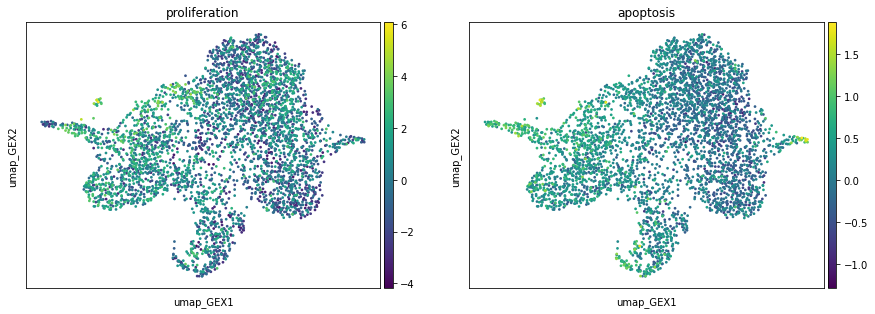

In [5]:
sc.pl.embedding(adata, basis="umap_GEX", color=["proliferation", "apoptosis"])

When preparing the problem, the above scores are used to compute the left marginals of our OT problems. By default, this is done via a birth death process ({cite}`schiebinger:19`).

In [6]:
tp = tp.prepare(time_key="day", joint_attr="X_pca")

We can visualize the prior estimates of the growth rates and assess their values. Note that cells which only occur in the target do not require a prior growth rate estimate. Hence, their value is set to `NaN`, and their color in the plot is gray.

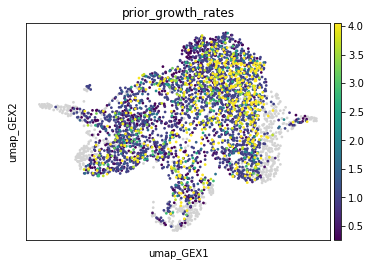

In [7]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates")

Assuming a cell with value `4.0` corresponds to day `2`, this means that this cell is expected to proliferate such that at day `3` the cell gave rise to another 3 cells. This indeed might be realistic. 

Nevertheless, if we would like to adapt our prior estimates, we can do this via the `marginal_kwargs` estimate in `~moscot.problems.time.TemporalProblem.prepare`. Either we can use the parameters corresponding to the birth process

```python
    beta_max: float = 1.7,
    beta_min: float = 0.3,
    beta_center: float = 0.25,
    beta_width: float = 0.5,
```

and the death process

```python
    delta_max: float = 1.7,
    delta_min: float = 0.3,
    delta_center: float = 0.1,
    delta_width: float = 0.2,
```



## A more tunable way of the prior marginal estimates

In some cases it might be easier to use the more easily tunable alternative prior growth rate estimation defined by

$s_i = \exp(\frac{(p_i - a_i)*(t_1 - t_0)}{scaling})$

where $p_i$ are the proliferation scores saved in {attr}`obs['proliferation'] <anndata.AnnData.obs>` and $a_i$ are the apoptosis scores saved in {attr}`obs['apoptosis'] <anndata.AnnData.obs>`.

This estimation is done if we pass `scaling` in `marginal_kwargs`.

In the following, we try different values of `scaling` to obtain a different range of prior marginal estimations. Note that some cells might be outliers, hence we truncate the values at the 99th percentile.

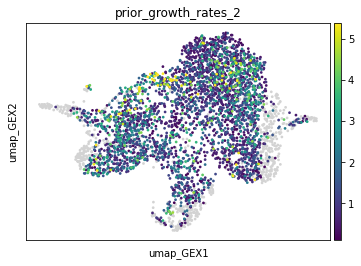

In [8]:
tp = tp.prepare(time_key="day", joint_attr="X_pca", marginal_kwargs={"scaling": 2})
adata.obs["prior_growth_rates_2"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates_2", vmax="p99")

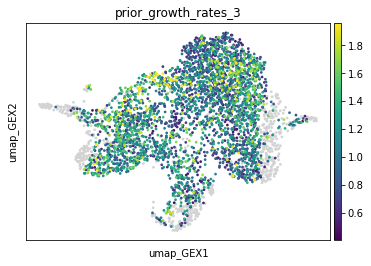

In [9]:
tp = tp.prepare(time_key="day", joint_attr="X_pca", marginal_kwargs={"scaling": 5})
adata.obs["prior_growth_rates_3"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates_3", vmax="p99")

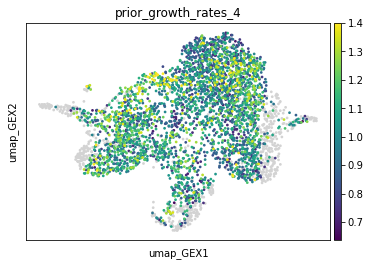

In [10]:
tp = tp.prepare(time_key="day", joint_attr="X_pca", marginal_kwargs={"scaling": 10})
adata.obs["prior_growth_rates_4"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates_4", vmax="p99")